In [11]:
import numpy as np 
import pandas as pd 
import seaborn as sb 
import matplotlib.pyplot as plt 
from abc import ABC, abstractmethod 
from typing import Callable
import enum 

In [2]:
"""To be implemented:
    1. 2D Wiener process
    2. Correlated GBMs
    3. Euler-Maruyama(i.e. CEV, etc ...)
"""

'To be implemented:\n    1. 2D Wiener process\n    2. Correlated GBMs\n    3. Euler-Maruyama(i.e. CEV, etc ...)\n'

#### Class: one dimensional uniform mesh

$\Pi_{a, b, \delta} = (t_i)_{i}$ such that
* $t_0 = a$, 
* $t_N = b$,
* $t_{i+1}-t_i = \delta,  \ \forall i$


In [3]:
class OneDimUniformMesh: 
    """A one dimensional uniform mesh"""
    def __init__(self, start_point: float = 0., end_point: float = 1., spacing: float = 0.1):
        """Constructor"""
        self.start_point = start_point 
        self.end_point = end_point 
        self.spacing = spacing 
        self.interval_length = end_point - start_point 
        self.num_samples = int(self.interval_length / spacing + 1) 
    
    def mesh(self) -> np.ndarray: 
        """Generates the mesh"""
        return np.linspace(self.start_point, self.end_point, num=self.num_samples)

#### Abstact class: Stochastic process

In [4]:
class StochasticProcess(ABC):
    """A one dimensional stochastic process """
    def __init__(self, time_mesh: OneDimUniformMesh):
        self.time_mesh = time_mesh
        
    @abstractmethod
    def sample_path(self) -> np.ndarray: 
        """Generate one sample path of the process"""
        return 
    
    @abstractmethod
    def simulate_paths(self, *args, **kwargs) -> np.ndarray: 
        """Generate multiple sample paths of the process"""
        return 
        

#### Class: one dimensional Wiener process

$ \mathbb{F} = (\mathcal{F}_s)_{s > 0}$ a filtration, $(W_t)_{t > 0}$ such that:
* $W_0 = 0$,
* $W_{t+h} - W_t \sim \mathcal{N}(0, h) = \sqrt{h}Z, Z \sim \mathcal{N}(0, 1)$
* $W_{t+h} - W_t$ independent of $\mathcal{F}_s, s \leq t$

In [5]:
class OneDimWienerProcess(StochasticProcess): 
    """A one dimensional Wiener process (Brownian Motion)"""
    
    def sample_path(self) -> np.ndarray: 
        """Generates one random sample path of the wiener process"""
        time_spacing = self.time_mesh.spacing
        increments = np.sqrt(time_spacing) * np.random.standard_normal((self.time_mesh.num_samples) - 1)
        process = np.zeros(self.time_mesh.num_samples)
        process[1:] = np.cumsum(increments)
        return process

    def simulate_paths(self, num_simulations: int) -> np.ndarray: 
        """Generates multiple observations of a wiener process"""
        simulations = [self.sample_path() for _ in range(num_simulations)]
        result = np.vstack(simulations).T
        return result 


#### Functions for plotting

In [6]:
def plot_path(time_array: np.ndarray, path_array: np.ndarray, ax = None): 
    """Line plot of one sample path of stochastic process"""
    sb.lineplot(x=time_array, y=path_array, ax=ax) 

def plot_simulations(time_array: np.ndarray, path_matrix: np.ndarray, 
                            ax = None, show_legends: bool = False): 
    """Line plots for multiple simulated stochastic processes"""
    num_simulations = path_matrix.shape[1] 
    columns = [f'X{i}' for i in range(num_simulations)]
    simulations = pd.DataFrame(path_matrix, index=time_array, columns=columns)
    sb.lineplot(data=simulations, ax=ax, legend=show_legends)

def plot_distribution_returns(process_array: np.ndarray): 
    """Plot the distribution of returns"""
    returns = np.diff(process_array) 
    sb.displot(data=returns)

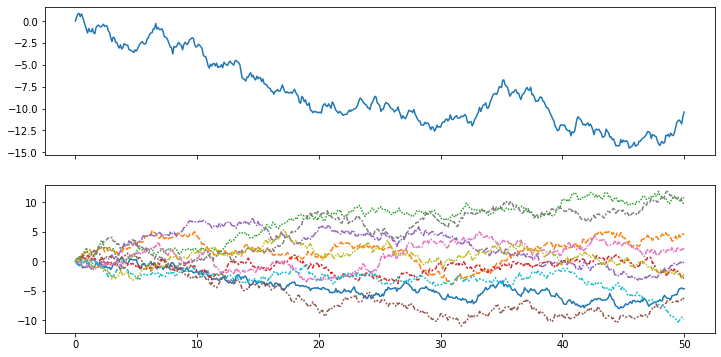

In [7]:
time = OneDimUniformMesh(start_point=0., end_point=50., spacing=.1)
wiener = OneDimWienerProcess(time)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
plot_path(time.mesh(), wiener.sample_path(), ax=axs[0])
plot_simulations(time.mesh(), wiener.simulate_paths(10), ax=axs[1])

#### Class: geometric brownian motion

A geometric brownian motion GBM is a stochastic process $(X_t)_{t}$ that satisfies: 
* $dX_t(\omega) = \mu X_t(\omega) dt + \sigma X_t(\omega) dW_t(\omega), X_0 = x_0 \in \mathbb{R}$ 

The solution is given by: 
* $X_t = X_0 \exp((\mu - \frac{\sigma ^ 2}{2})t + \sigma W_t)$

In [8]:
class GeometricBrownianMotion(StochasticProcess): 
    """A class representing a one dim solution to Black-Scholes SDE"""
    def __init__(self, mu: float, sigma: float, time_mesh: OneDimUniformMesh):
        super().__init__(time_mesh)
        self.mu = mu 
        self.sigma = sigma 
        self.wiener_process = OneDimWienerProcess(self.time_mesh)

    def sample_path(self, initial_value: float = 1.) -> np.ndarray:
        """Generates one path of a geometric brownian motion"""
        brownian_motion = self.wiener_process.sample_path() 
        time = self.time_mesh.mesh()
        process = (self.mu - self.sigma ** 2 / 2) * time + self.sigma * brownian_motion
        process = initial_value * np.exp(process)
        return process
    
    def simulate_paths(self, num_simulations: int, initial_value: float = 1.) -> np.ndarray:
        """Generates multiple observations of the GBM process"""
        simulations = [self.sample_path(initial_value) for _ in range(num_simulations)]
        result = np.vstack(simulations).T
        return result
        

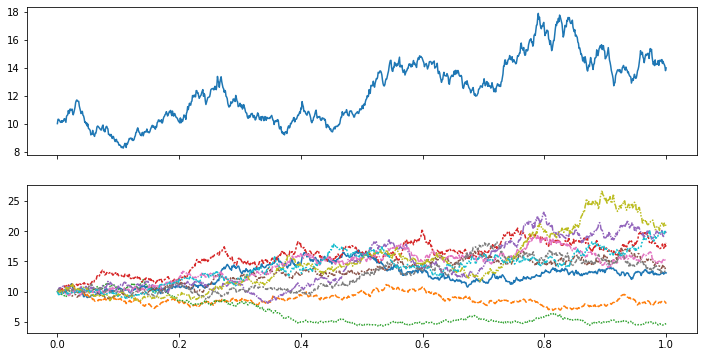

In [9]:
time = OneDimUniformMesh(start_point=0., end_point=1., spacing=0.001)
process = GeometricBrownianMotion(0.25, 0.5, time)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
plot_path(time.mesh(), process.sample_path(10), ax=axs[0])
plot_simulations(time.mesh(), process.simulate_paths(10, 10), ax=axs[1])

#### Class: General model

* $dX_t = \mu(t, X_t) dt + \sigma(t, X_t) dW_t$

In [25]:
class NumericalMethod(enum.Enum):
    EULER_MARUYAMA = 1 
    MILSTEIN = 2 
    
class DiffusionProcess(StochasticProcess): 
    """A general diffusion process"""
    def __init__(self, mu: Callable, sigma: Callable,
                 time_mesh: OneDimUniformMesh, der_sigma: Callable = None): 
        self.mu = mu 
        self.sigma = sigma
        self.der_sigma = der_sigma
        self.time_mesh = time_mesh 
        self.wiener_process = OneDimWienerProcess(self.time_mesh)
        self.is_milstein = int(der_sigma is not None); 

    def sample_path(self, initial_value: float = 1.): 
        brownian_motion = self.wiener_process.sample_path()
        time = self.time_mesh.mesh() 
        delta_t = self.time_mesh.spacing

        process = np.zeros(self.time_mesh.num_samples)
        process[0] = initial_value
        for i in range(1, self.time_mesh.num_samples):
            drift = self.mu(time[i-1], process[i-1])
            vol = self.sigma(time[i-1], process[i-1])
            dW = brownian_motion[i] - brownian_motion[i-1]
            d_process = drift * delta_t + vol * dW 
            if (self.is_milstein): 
                d_vol = self.der_sigma(time[i-1], process[i-1])
                d_process += 0.5 * vol * d_vol * (dW ** 2 - delta_t)
            process[i] = d_process + process[i-1]
        return process

    def simulate_paths(): 
        return NotImplementedError

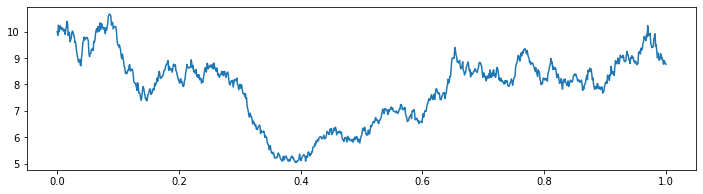

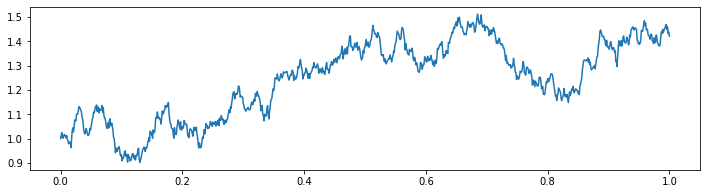

In [29]:
time_mesh = OneDimUniformMesh(0, 1, 0.001)

# Geometric brownian motion
MU, SIGMA = 0.25, 0.5
gbm = DiffusionProcess(lambda t, x: MU * x, lambda t, x: SIGMA * x, time_mesh, lambda t, x: SIGMA)
fig, ax = plt.subplots(figsize=(12,3))
plot_path(time_mesh.mesh(), gbm.sample_path(10), ax)

# Langevine equation 1D 
langevine = DiffusionProcess(lambda t, x: MU * x, lambda t, x: SIGMA, time_mesh)
fig, ax = plt.subplots(figsize=(12, 3))
plot_path(time_mesh.mesh(), langevine.sample_path(1), ax)
